In [1]:
# Import libraries and packages
import subprocess
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from google.colab import drive
from tqdm import tqdm

In [2]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


# Global Variables

In [3]:
WORKING_DIR = "/content/drive/MyDrive/NaCo/negative-selection"

# Data Processing

## Helper Functions for File Reading

In [4]:
def read_sequences(file_path):
    with open(file_path, 'r') as file:
        sequences = [line.strip() for line in file if line.strip()]
    return sequences

def read_labels(file_path):
    with open(file_path, 'r') as file:
        labels = [int(line.strip()) for line in file if line.strip()]
    return labels

## Sequence Preprocessing

In [5]:
# We used this function in our final experiments
def non_overlapping_substrings_fixed_length(seq, k, drop_last=False):
    chunks = []
    n = len(seq)
    for i in range(0, n, k):
        if drop_last and i + k > n:
            break
        chunk = seq[i : i + k]
        if len(chunk) < k:
            chunk = chunk.ljust(k, '-')
        chunks.append(chunk)
    return chunks

# This function was only used in some initial experiments, and included for completeness
def all_substrings_fixed_length(seq, k):
    """
    Return all k-length substrings (sliding windows).
    """
    n = len(seq)
    if n < k:
        seq = seq.ljust(k, '-') ## add fill character to short strings
        return [seq]
    return [seq[i:i+k] for i in range(n - k + 1)]

# Helper function to select the desired chunking method
def get_chunk_function(non_overlapping, chunk_size, drop_last=False):
    """
    Returns the appropriate chunking function based on the 'non_overlapping' flag.
    """
    if non_overlapping:
        return lambda s: non_overlapping_substrings_fixed_length(s, chunk_size, drop_last)
    else:
        return lambda s: all_substrings_fixed_length(s, chunk_size)

def create_chunked_file(sequences, chunk_size, output_file, drop_last=False, non_overlapping=True):
    """
    Chunk sequences and write them to output_file.
    Can be used for both training and test sequences.
    """
    chunk_function = get_chunk_function(non_overlapping, chunk_size, drop_last)  # Get the chunking function

    with open(output_file, 'w') as out:
        for seq in sequences:
            for chunk in chunk_function(seq):  # Use the returned function
                out.write(chunk + "\n")

# Main Function to Run the Negative Selection Algorithm

In [6]:
def run_negative_selection(train, test, n=10, r=4, alphabet=None):
    """
    Run negsel2.jar with the given parameters.
    train = absolute path to the 'chunked' training file
    test  = absolute path to file that will be fed to stdin
    """
    try:
      cmd = f"java -jar negsel2.jar -alphabet {alphabet} -self {train} -n {n} -r {r} -c -l < {test}"
      output = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT, text=True, cwd=WORKING_DIR)
      scores = np.fromstring(output, sep="\n")
      return scores

    except subprocess.CalledProcessError as e:
      print(f"Error: {e}")
      print("Command output:", e.output)
      return None

# Sequence Classification

In [7]:
def classify_sequences(sequences, chunk_size, train_chunked_file, alphabet_file, n, r,
                         drop_last=False, non_overlapping=True, aggr="avg"):
    """
    Classify a list of test sequences by chunking each one, running the classifier,
    and returning a list of average scores.
    """
    classification_scores = []
    # Choose the appropriate chunking function for test sequences
    chunk_function = get_chunk_function(non_overlapping, chunk_size, drop_last)

    tmp_file = os.path.join(WORKING_DIR, "tmp_test_chunks.txt")
    for seq in tqdm(sequences, desc=f"Classifying test sequences-n={n}, r={r}"):
        # Write test sequence chunks to a temporary file
        with open(tmp_file, 'w') as out:
            for chunk in chunk_function(seq):
              out.write(chunk + "\n")
        # Get scores from the classifier
        chunk_scores = run_negative_selection(
            train=train_chunked_file,
            test=tmp_file,
            n=n,
            r=r,
            alphabet=alphabet_file
        )
        if chunk_scores is None or len(chunk_scores) == 0:
          classification_scores.append(0.0)
        else:
          if aggr == "avg": # For the final experiments Average Aggregation was used
            avg_score = np.mean(chunk_scores)
            classification_scores.append(avg_score)
          elif aggr == "max":
            max_score = np.max(chunk_scores)
            classification_scores.append(max_score)

    return classification_scores

# Compute Normal & Anomaly Scores

In [8]:
def get_scores(classification_scores, labels):
  normal_scores = np.array([score for score, lab in zip(classification_scores, labels) if lab == 0])
  anomaly_scores_arr = np.array([score for score, lab in zip(classification_scores, labels) if lab == 1])
  return normal_scores, anomaly_scores_arr

# Validation

### For Running a Single Experiment

In [14]:
def plot_ROC_curve_single(fpr, tpr, roc_auc, r):
    plt.figure()
    plt.plot(fpr, tpr, color='orange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line
    plt.fill_between(fpr, tpr, color='lightblue', alpha=0.5)
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title(f"ROC Curve for r={r}")
    plt.legend(loc="lower right")
    plt.show()

def AUC_analysis_single(normal_scores, anomaly_scores, r):
    normal_labels = np.zeros_like(normal_scores)
    anomaly_labels = np.ones_like(anomaly_scores)
    all_scores = np.concatenate([normal_scores, anomaly_scores])
    all_labels = np.concatenate([normal_labels, anomaly_labels])
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plot_ROC_curve_single(fpr, tpr, roc_auc, r)

### For Runing Multiple Experiments

In [20]:
def AUC_analysis(normal_scores, anomaly_scores):
    # Create labels
    normal_labels = np.zeros_like(normal_scores)  # 0 for normal
    anomaly_labels = np.ones_like(anomaly_scores)   # 1 for anomalous
    # Concatenate scores and labels
    all_scores = np.concatenate([normal_scores, anomaly_scores])
    all_labels = np.concatenate([normal_labels, anomaly_labels])
    fpr, tpr, _ = roc_curve(all_labels, all_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def plot_ROC_curves(fpr_list, tpr_list, roc_auc_list, r_values, n, sys_data_dir=None, file_index=None):
    """
    Plots multiple ROC curves in a grid.

    Parameters:
      - fpr_list: List of false positive rate arrays.
      - tpr_list: List of true positive rate arrays.
      - roc_auc_list: List of AUC values.
      - r_values: List of r parameter values (for titles).
    """
    num_r = len(r_values)
    # Determine grid dimensions based on number of r values
    cols = math.ceil(math.sqrt(num_r))
    rows = math.ceil(num_r / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Flatten axes for iteration (even if there's a single row/column)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Hide unused subplots, if any
    for ax in axes[num_r:]:
        ax.set_visible(False)

    # Plot each ROC curve
    for i, (fpr, tpr, roc_auc, r) in enumerate(zip(fpr_list, tpr_list, roc_auc_list, r_values)):
        ax = axes[i]
        ax.plot(fpr, tpr, color='orange', label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
        ax.fill_between(fpr, tpr, color='lightblue', alpha=0.5)   # Fill under curve
        ax.set_xlabel("False Positive Rate (1 - Specificity)")
        ax.set_ylabel("True Positive Rate (Sensitivity)")
        ax.set_title(f"ROC Curve (n={n}, r={r})")
        ax.legend(loc="lower right")

    plt.tight_layout()
    if sys_data_dir is not None and file_index is not None:
      save_plots(file_index, sys_data_dir, fig, axes,num_r, r_values, n)

    plt.show()

# Helper function for saving plots
def save_plots(file_index, sys_data_dir, fig, axes,num_r, r_values, n):
  plots_dir = os.path.join(WORKING_DIR, "syscalls", sys_data_dir, "plots")
  subplot_dir = os.path.join(WORKING_DIR, "syscalls", sys_data_dir, "subplots")
  # Create directories if they don't exist
  os.makedirs(plots_dir, exist_ok=True)
  os.makedirs(subplot_dir, exist_ok=True)
  # Save the entire figure (all subplots together)
  full_fig_filename = os.path.join(subplot_dir, f"{sys_data_dir}-{file_index}-ROC-curve-subplot-n-{n}.png")
  plt.savefig(full_fig_filename)

  # Draw the canvas to update bounding boxes
  fig.canvas.draw()

  # Save each individual subplot using its tight bounding box
  for i, (ax, r) in enumerate(zip(axes[:num_r], r_values)):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
    subplot_filename = os.path.join(plots_dir, f"{sys_data_dir}-{file_index}-ROC-curve-n-{n}-r-{r}.png")
    fig.savefig(subplot_filename, bbox_inches=bbox)

  print(f"Plots and subplots for n:{n} saved!")

# Demo's

## Demo run on a Single File With Average Aggregation

In [17]:
# Parameters
# Config: use absolute paths
alpha_file = os.path.join(WORKING_DIR, "syscalls", "snd-cert", "snd-cert.alpha")
train_raw_file = os.path.join(WORKING_DIR, "syscalls", "snd-cert", "snd-cert.train")
test_raw_file  = os.path.join(WORKING_DIR, "syscalls", "snd-cert", "snd-cert.1.test")
label_file     = os.path.join(WORKING_DIR, "syscalls", "snd-cert", "snd-cert.1.labels")
chunk_size     = 10
n_param        = 10
r_param        = 4

alpha_param = "file://" + alpha_file
# Read training sequences and create chunked training file
train_sequences = read_sequences(train_raw_file)
train_chunked_file = os.path.join(WORKING_DIR, "snd-cert.train.chunked")
create_chunked_file(train_sequences, chunk_size, train_chunked_file, drop_last=False, non_overlapping=True)

# Read test sequences and labels
test_sequences = read_sequences(test_raw_file)
labels = read_labels(label_file)
print("Number of test sequences:", len(test_sequences))

Number of test sequences: 100


Classifying test sequences-n=10, r=4: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


[0.0, 18.339727384947224, 0.0, 7.278828852026805, 0.0, 10.93233977333974, 14.465763298907513, 0.0, 0.0, 0.0, 14.566689620021787, 0.0, 0.0, 18.19350167194425, 18.481374034356772, 25.6035235552171, 18.555876353958798, 3.580462314434746, 0.0, 11.019880155357919]


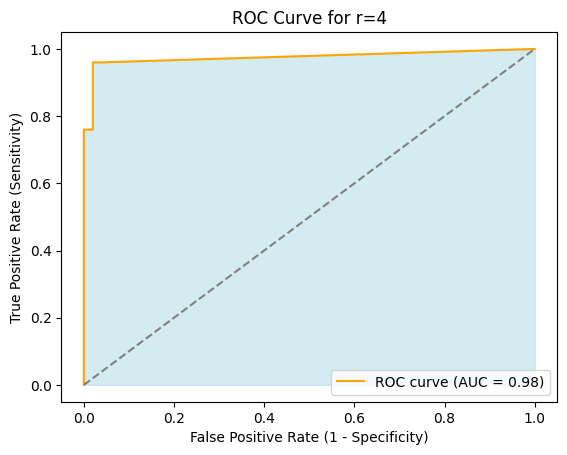

In [18]:
# Classify test sequences
classification_scores = classify_sequences(test_sequences, chunk_size, train_chunked_file,
                                        alpha_param, n_param, r_param,
                                        drop_last=False, non_overlapping=True,
                                           aggr="avg")
print()
print(classification_scores[0:20])
normal_scores, anomaly_scores_arr = get_scores(classification_scores, labels)
AUC_analysis_single(normal_scores, anomaly_scores_arr, r_param)



## Demo run on a Single File With Max Aggregation

Classifying test sequences-n=10, r=4: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]



[0.0, 37.403030764021054, 0.0, 36.40303670166766, 0.0, 37.37154117130066, 37.62820637862219, 0.0, 0.0, 0.0, 37.62820637862219, 0.0, 0.0, 37.139712023122144, 37.39429218596092, 37.40272074274366, 37.61391358728196, 35.80462314434746, 0.0, 37.39292644161686]


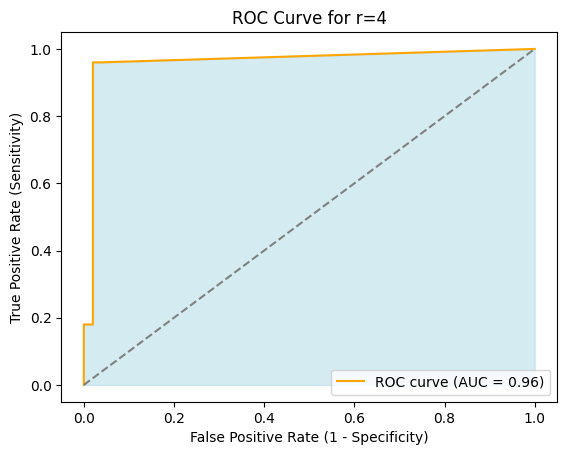

In [19]:
# Classify test sequences
classification_scores = classify_sequences(test_sequences, chunk_size, train_chunked_file,
                                        alpha_param, n_param, r_param,
                                        drop_last=False, non_overlapping=True,
                                           aggr="max")
print()
print(classification_scores[0:20])
normal_scores, anomaly_scores_arr = get_scores(classification_scores, labels)
AUC_analysis_single(normal_scores, anomaly_scores_arr, r_param)

# Experiments

## Grid Search Function for Running Multiple Experiments

In [10]:
def grid_search(WORKING_DIR,
                sys_data_dir,
                alpha_file_name,
                train_file_name,
                n_values,
                r_values,
                test_files,
                label_files,
                drop_last=False,
                non_overlapping=True,
                aggr="avg"):
    # Create a common data directory path.
    data_dir = os.path.join(WORKING_DIR, "syscalls", sys_data_dir)

    # Define file paths for the alpha and training files.
    alpha_file = os.path.join(data_dir, alpha_file_name)
    train_raw_file = os.path.join(data_dir, train_file_name)
    alpha_param = f"file://{alpha_file}"

    # Read training sequences once.
    train_sequences = read_sequences(train_raw_file)

    # Iterate over each test file and its corresponding label file.
    for index, (test_file, label_file) in enumerate(zip(test_files, label_files)):
        file_index = index + 1  # Index starts from 1
        results = {}  # Dictionary to store AUC values for each configuration
        test_raw_file = os.path.join(data_dir, test_file)
        label_path = os.path.join(data_dir, label_file)

        test_sequences = read_sequences(test_raw_file)
        test_labels = read_labels(label_path)
        print(f"Number of test sequences in {test_file}: {len(test_sequences)}")

        # Iterate over each n value (chunk size).
        for n in n_values:
            chunk_size = n
            # Define the path for the chunked training file.
            train_chunked_file = os.path.join(WORKING_DIR, f"{sys_data_dir}-n-{chunk_size}.train.chunked")
            create_chunked_file(train_sequences, chunk_size, train_chunked_file,
                                drop_last=False, non_overlapping=True)

            # Filter r_values to only include those <= current n
            valid_r_values = [r for r in r_values if r <= n]

            # Lists to accumulate ROC metrics for each valid r value.
            fpr_list, tpr_list, auc_list = [], [], []

            # Iterate over each valid r value.
            for r in valid_r_values:
                # Classify test sequences using the current parameters.
                classification_scores = classify_sequences(
                    test_sequences,
                    chunk_size,
                    train_chunked_file,
                    alpha_param,
                    n,  # current n
                    r,  # current r
                    drop_last=drop_last,
                    non_overlapping=non_overlapping,
                    aggr=aggr
                )
                normal_scores, anomaly_scores_arr = get_scores(classification_scores, test_labels)
                fpr, tpr, roc_auc = AUC_analysis(normal_scores, anomaly_scores_arr)

                # Store results and accumulate ROC metrics.
                results[(test_file, n, r)] = roc_auc
                fpr_list.append(fpr)
                tpr_list.append(tpr)
                auc_list.append(roc_auc)

            # Plot ROC curves for all valid r values for the current n.
            plot_ROC_curves(fpr_list, tpr_list, auc_list, valid_r_values, n, sys_data_dir, file_index)

        # Determine and print the best configuration.
        print(f"Results: {results}")
        best_config = max(results, key=results.get)
        best_auc = results[best_config]
        print("\nBest configuration:")
        print(f"Test File: {best_config[0]}, Chunk Size (n): {best_config[1]}, r: {best_config[2]}, AUC: {best_auc}")


## Global Experiment Parameters

In [13]:
N_VALUES = [10]
R_VALUES = [1, 2, 3, 4, 5, 6, 7, 8, 9]

## Experiments snd-cert
### Parameters

In [11]:
snd_cert_sys_data_dir = "snd-cert"
alpha_file_name = "snd-cert.alpha"
train_file_name = "snd-cert.train"
snd_cert_test_files = ["snd-cert.1.test", "snd-cert.2.test", "snd-cert.3.test"]
snd_cert_labels = ["snd-cert.1.labels", "snd-cert.2.labels", "snd-cert.3.labels"]

## Run this cell to reproduce the results for snd-cert

In [19]:
# Run this cell to reproduce the
grid_search(WORKING_DIR,
                snd_cert_sys_data_dir,
                alpha_file_name,
                train_file_name,
                N_VALUES,
                R_VALUES,
                snd_cert_test_files,
                snd_cert_labels,
                drop_last=False,
                non_overlapping=True,
                aggr="avg"
            )

## Experiments snd-unm
### Parameters

In [ ]:
snd_unm_sys_data_dir = "snd-unm"
alpha_file_name = "snd-unm.alpha"
train_file_name = "snd-unm.train"
snd_unm_test_files = ["snd-unm.1.test", "snd-unm.2.test", "snd-unm.3.test"]
snd_unm_labels = ["snd-unm.1.labels", "snd-unm.2.labels", "snd-unm.3.labels"]

## Run this cell to reproduce the results for snd-unm

In [ ]:
grid_search(WORKING_DIR,
                snd_unm_sys_data_dir,
                alpha_file_name,
                train_file_name,
                N_VALUES,
                R_VALUES,
                snd_unm_test_files,
                snd_unm_labels,
                drop_last=False,
                non_overlapping=True,
                aggr="avg"
            )